In [307]:
import datetime
import gc
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')
%matplotlib inline

In [308]:
df = pd.read_csv('/users/Сергей/Homework_Data_Science/Project/train.csv')

X = df.copy()
y = df[['Price']]

X_final = pd.read_csv('/users/Сергей/Homework_Data_Science/Project/test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


3931

In [309]:
class Data:
    
    def __init__(self):

        self.area_min = 10
        self.area_max = 300
        self.LivingAreaSquare_min = 10
        self.LivingAreaSquare_max = 250
        self.Rooms_min = 1 
        self.Rooms_max = 7
        self.HouseFloor_min = 1
        self.HouseFloor_max = 95 
        self.KitchenArea_min = 4 
        self.KitchenArea_max = 35
        self.current_year = datetime.datetime.now().year
        self.medians = None
        self.DistrictLimit = None
        self.SquareMeterPrice_by_DistrictId = None
          
    def fit(self, df):
        self.medians = df[['LifeSquare', 'HouseFloor']].median()       
        district = X['DistrictId'].value_counts()
        district = district[district > 50] 
        self.DistrictLimit = district
        df_temp = df.loc[((df['Square'] > self.area_min) & (df['Square'] < self.area_max))]
        df_temp["SquareMeterPrice"] = df_temp["Price"] / df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'}) 
        del df_temp
        
    def transform(self, df):
        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year  
        df.loc[(df['KitchenSquare'] < self.KitchenArea_min), 'KitchenSquare'] = self.KitchenArea_min
        df.loc[(df['KitchenSquare'] > self.KitchenArea_max), 'KitchenSquare'] = self.KitchenArea_max
        df.loc[(df['LifeSquare'] < self.LivingAreaSquare_min), 'LifeSquare'] = self.LivingAreaSquare_min
        df.loc[(df['LifeSquare'] > self.LivingAreaSquare_max), 'LifeSquare'] = self.LivingAreaSquare_max
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        df.loc[(df['Square'] > self.area_max), 'Square'] = self.area_max
        df.loc[(df['Square'] < self.area_min), 'Square'] = self.area_min 
        df.loc[(df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        df.loc[(df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        return df
    
    def features(self, df):
        df['LivingSquare'] = (df['Square'] / df['LifeSquare'])
        df['KitchenSquare'] = (df['Square'] / df['KitchenSquare'])
        df['RoomSquare'] = (df['LifeSquare'] / df['Rooms'])

        df = df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df['AverageSquareMeterPrice'].fillna(df['AverageSquareMeterPrice'].median(), inplace=True)        
        return df

In [310]:
data_inst = Data()

data_inst.fit(X)
X = data_inst.transform(X)
X = data_inst.features(X)

X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

In [311]:
feature_names = ['AverageSquareMeterPrice',  'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor','HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3','Shops_1', 'LivingSquare', 'RoomSquare',]
X1 = X[feature_names]
X1_final = X_final[feature_names]
X1_final

,AverageSquareMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Helthcare_2,Ecology_1,Social_1,Social_2,Social_3,Shops_1,LivingSquare,RoomSquare
0,3021.675025,2.0,49.882643,33.432782,8.313774,6,14.0,1972,0,0.310199,11,2748,1,0,1.492028,16.716391
1,3355.343060,2.0,69.263183,32.781260,17.315796,6,1.0,1977,0,0.075779,6,1437,3,2,2.112890,16.390630
2,7919.443196,1.0,13.597819,15.948246,1.133152,2,5.0,1909,5,0.000000,30,7538,87,5,0.852622,15.948246
3,4116.345095,2.0,73.046609,51.940842,8.116290,22,22.0,2007,3,0.101872,23,4583,3,3,1.406342,25.970421
4,2766.023246,1.0,47.527111,43.387569,11.881778,17,17.0,2017,0,0.072158,2,629,1,0,1.095408,43.387569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4055.974766,3.0,67.133911,50.809797,11.188985,5,9.0,1973,1,0.000170,36,5992,0,1,1.321279,16.936599
4996,3212.333928,1.0,40.198472,21.807061,4.019847,12,17.0,2017,0,0.007122,1,264,0,1,1.843370,21.807061
4997,4106.495969,3.0,77.842178,48.282625,8.649131,23,22.0,1989,5,0.090799,74,19083,2,15,1.612219,16.094208
4998,2818.749357,2.0,81.305222,32.781260,20.326306,4,1.0,1977,0,0.072158,2,629,1,0,2.480235,16.390630


In [312]:
model = LGBMRegressor(max_depth=10, n_estimators=500, random_state=42)
cv_score = cross_val_score(model, X1, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=42))
model.fit(X1, y)
mean = cv_score.mean()
std = cv_score.std()
print('{:.3f};{:.3f}' .format(mean,std))

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.752;0.021


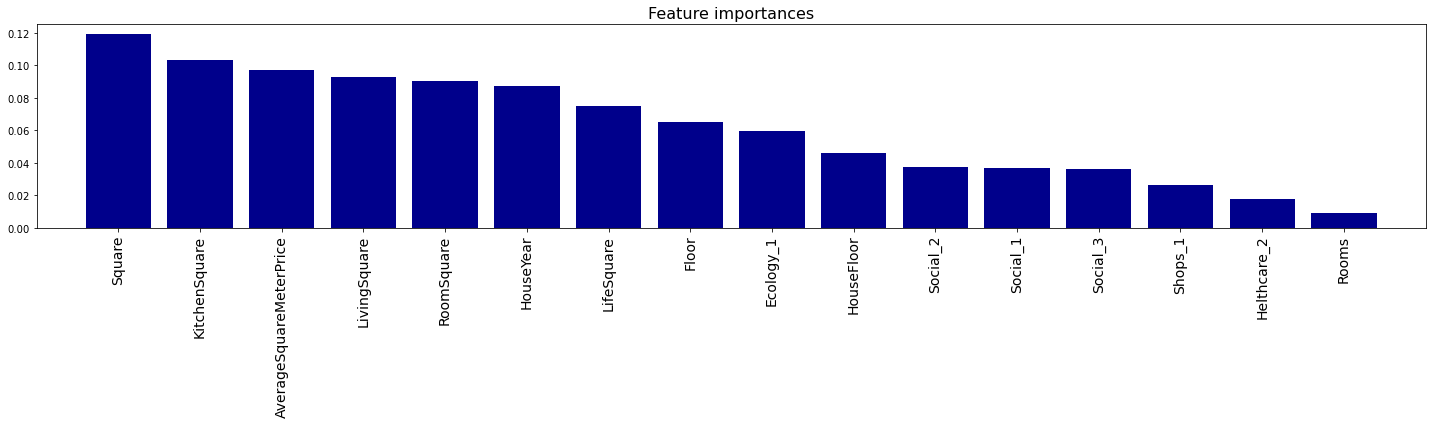

In [313]:
def plot_feature_importances(importances, X1):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X1.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X1.shape[1]), X1.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X1.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X1=X1)

In [314]:
y_pred_final = model.predict(X1_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,151964.242567
1,15856,219232.659293
2,5480,306793.811928
3,15664,315845.983174
4,14275,148740.080654
